In [1]:
%matplotlib inline
import bioread
import numpy as np
import pandas as pd
import neurokit2 as nk
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle
import pingouin as pg

In [2]:
class Segment(object):
    def __init__(self, name, start_index_text, start_index, seg_before):
        self.name = name
        self.start_index_text = start_index_text
        self.start_index = start_index
        self.end_index_text = ""
        self.end_index = 0
        self.before = seg_before
        self.after = None
        self.marker_inside_text = ""
        self.marker_inside_index = 0

    def make_df(self, file):
        data = {}
        for channel in file.named_channels:
            signal = np.array(file.named_channels[channel].data[self.start_index:self.end_index])
            data[channel] = signal
        self.df = pd.DataFrame(data)
        print('Dataframe of {0}:'.format(self.name))
        #print(self.df)

In [3]:
class Filedata(object):
    def __init__(self, filename):
        self.filename = filename
        self.segments = {}
        #self.analyze_ecg = {}
        #self.analyze_eda = {}

    def preparedata(self):
        name_seg_before = None
        name_seg_after = None
        file = bioread.read_file('RAW_data/labeled/{0}.acq'.format(self.filename))
        for m in file.event_markers:
            if m.text == 'post nf1_VR (crashed)' and self.filename == 'PB1_only_part2':
                continue

            if m.text == 'recording interrupted' and self.filename == 'PB12':
                m.text = 'stress2_MIST_end'

            if m.text == 'stress1_ABBA_start' and m.sample_index == 946410 and self.filename == 'PB13':
                m.text = "stress1_ABBA_end"

            if m.text == 'stress2_MIST_end' and self.filename == 'PB23':
                m.text = "stress1_MIST_end"

            if m.text == '' and self.filename == 'PB27':
                m.text = "nf2_VR_start"

            if m.text == '' and self.filename == 'PB15':
                m.text = "nf2_VR_end"

            if m.text == '' and self.filename in ['PB4', 'PB16', 'PB22', 'PB25', 'PB12-partie_2']:
                continue

            if m.text == 'baseline':
                name = m.text
                current_seg = Segment(name, m.text, m.sample_index, name_seg_before)
                self.segments[name] = current_seg
                name_seg_before = name
            elif m.text.startswith("Segment "):
                continue
            elif m.text.endswith("_start"):
                name = m.text.removesuffix("_start")
                current_seg = Segment(name, m.text, m.sample_index, name_seg_before)
                self.segments[name] = current_seg
                if name_seg_before != None:
                    self.segments[name_seg_before].after = name
                name_seg_before = name
            elif m.text.endswith("_end"):
                name = m.text.removesuffix("_end")
                current_seg = self.segments[name]
                current_seg.end_index_text = m.text
                current_seg.end_index = m.sample_index
                current_seg.make_df(file)
                name_seg_before = name
            elif m.text.endswith("_unlimited"):
                if name_seg_before != None:
                    print("unlimited: " + m.text)
                    self.segments[name_seg_before].marker_inside_text = m.text
                    self.segments[name_seg_before].marker_inside_index = m.sample_index
            else:
                print("unknown: " + m.text)
            print(m.text)

        if self.filename in ['PB4', 'PB7', 'PB12', 'PB13', 'PB14', 'PB15', 'PB16', 'PB17', 'PB21', 'PB25']:
            current_seg = self.segments['baseline']
            current_seg.end_index_text = self.segments['stress1_ABBA'].start_index_text
            current_seg.end_index = self.segments['stress1_ABBA'].start_index
            current_seg.make_df(file)

        if self.filename in ['PB2', 'PB3', 'PB5', 'PB19', 'PB22', 'PB23', 'PB24', 'PB26', 'PB27']:
            current_seg = self.segments['baseline']
            current_seg.end_index_text = self.segments['stress1_MIST'].start_index_text
            current_seg.end_index = self.segments['stress1_MIST'].start_index
            current_seg.make_df(file)

        if self.filename in ['PB12-partie_2']:
            current_seg = self.segments['baseline']
            current_seg.end_index_text = self.segments['stress2_MIST'].start_index_text
            current_seg.end_index = self.segments['stress2_MIST'].start_index
            current_seg.make_df(file)    

In [4]:
def ECG_report(df, name, fdat, fnam):
    print('Segment {0}.{1}:'.format(fnam, name))
    # Preprocess ECG signal
    clean_signals, info = nk.ecg_process(df['ECG (.5 - 35 Hz)'], sampling_rate=1000)
    # Visualize
    nk.ecg_plot(clean_signals, info)
    fig = plt.gcf()
    fig.savefig("ecg_proccess_{0}_{1}.png".format(fnam, name))
    plt.close()
    # Analyze
    analyze_df = nk.ecg_analyze(clean_signals, sampling_rate=1000)
    print('ECG analyze output of segment {0}.{1}:'.format(fnam, name))
    print(analyze_df)
    fdat.analyze_ecg = analyze_df
    #for col in analyze_df:
    #    print(col)
    print(analyze_df['HRV_MeanNN'].apply(lambda x: np.array(x).flatten()[0]))
    #print(analyze_df['HRV_MeanNN'].iloc[0][0][0])
    print(analyze_df['HRV_SDNN'].apply(lambda x: np.array(x).flatten()[0]))
    #print(analyze_df.iloc[0]['HRV_SDNN'][0][0])
    print(analyze_df['HRV_RMSSD'].apply(lambda x: np.array(x).flatten()[0]))
    #print(analyze_df.iloc[0]['HRV_RMSSD'][0][0])

In [5]:
def EDA_report(df, name, fdat, fnam):
    reportname = 'EDAreport_{0}_{1}.html'.format(fnam, name)
    signals, info = nk.eda_process(df['EDA (0 - 35 Hz)'], sampling_rate=1000, report=reportname)
    #signals, info = nk.eda_process(df['EDA (0 - 35 Hz)'], sampling_rate=1000, report="text")
    #signals, info = nk.eda_process(df['EDA (0 - 35 Hz)'], sampling_rate=1000)
    nk.eda_plot(signals, info)
    #fig = plt.gcf()
    #fig.savefig("eda_{0}_{1}.png".format(fnam, name))
    plt.show()
    plt.close(fig)
    print('EDA of segment {0}.{1}:'.format(fnam, name))
    #print(signals)
    #print(info)
    analyze_df = nk.eda_analyze(signals, sampling_rate=1000)
    print(analyze_df)
    fdat.analyze_eda = analyze_df

In [6]:
def sort_filelist(l):
    import re
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum = lambda key: [convert(c) for c in re.split(r'PB(\d+)', key)]
    l.sort(key=alphanum)
    return l

In [7]:
def delta(orig, dest, df):
    # List of columns to analyze
    metrics = ['ECG_Rate_Mean', 'HRV_RMSSD', 'HRV_SDNN', 'HRV_MeanNN', 'EDA_Tonic_Mean', 'EDA_Tonic_SD', 'SCR_Peaks_Amplitude_Mean', 'Sympathetic_Percent', 'SCR_Frequency_PerMin', 'Unlim_Duration_Blk']

    # Pivot - this creates a DataFrame where columns are (Metric, Segment)
    pivoted_all = df.pivot(index='Participant', columns='Segment', values=metrics)
    #print(pivoted_all)

    # Subtract the entire 'orig' slice from the 'dest' slice
    # .xs (cross-section) allows us to select all metrics for one specific Segment
    df_dest = pivoted_all.xs(dest, axis=1, level='Segment')
    df_orig = pivoted_all.xs(orig, axis=1, level='Segment')

    deltas = df_dest - df_orig

    #print(f"Deltas from {orig} to {dest}:")
    #print(deltas)
    return deltas


In [8]:
def main():
    # Unpickling (deserializing) from a file
    with open('../dfmaster.pkl', 'rb') as f:
        master_df = pickle.load(f)
    print(master_df)
    # Fix PB12 with values from B12-partie_2
    # Define the segments to be replaced
    target_segments = ['stress2_MIST', 'nf2_2D']
    # Extract the "Source" data (from PB12-partie_2)
    # We make a .copy() to avoid modifying the original dataframe accidentally
    source_data = master_df[
        (master_df['Participant'] == 'PB12-partie_2') &
        (master_df['Segment'].isin(target_segments))].copy()
    # Change the ID in the source data to match the "Target" (PB12)
    source_data['Participant'] = 'PB12'
    # Remove the "Old/Corrupt" segments from the target (PB12)
    # This prevents the 'Duplicate entries' error in your delta function
    master_df = master_df.drop(
        master_df[
            (master_df['Participant'] == 'PB12') &
            (master_df['Segment'].isin(target_segments))
        ].index
    )
    # Append the "New" data from PB12-partie_2 into the master dataframe
    master_df = pd.concat([master_df, source_data], ignore_index=True)
    ## 6. Optional: Remove the temporary 'PB12-partie_2' rows if you no longer need them
    master_df = master_df[master_df['Participant'] != 'PB12-partie_2']
    print("Final segments for PB12:")
    print(master_df.query("Participant == 'PB12'")['Segment'].unique())
    # Unpickling (deserializing) from a file
    #with open('dfmasterV0.pkl', 'rb') as f:
    with open('../results.pkl', 'rb') as f:
        fdatas = pickle.load(f)
    Group1 = ['PB2', 'PB19', 'PB23', 'PB24']
    Group4 = ['PB4', 'PB13', 'PB15', 'PB17', 'PB21']
    Group2 = ['PB3', 'PB5', 'PB22', 'PB26', 'PB27']
    Group3 = ['PB7', 'PB14', 'PB16', 'PB25', 'PB12']
    # 1. Create a mapping dictionary
    group_map = {}
    for pb in Group1: group_map[pb] = 'Group1'
    for pb in Group2: group_map[pb] = 'Group2'
    for pb in Group3: group_map[pb] = 'Group3'
    for pb in Group4: group_map[pb] = 'Group4'
    # 2. Add the column to your master_df
    master_df['Experiment_Group'] = master_df['Participant'].map(group_map)
    group_configs = {
        'Group1': [('stress1_MIST', 'nf1_VR'), ('stress2_ABBA', 'nf2_2D')],
        'Group4': [('stress1_ABBA', 'nf1_2D'), ('stress2_MIST', 'nf2_VR')],
        'Group2': [('stress1_MIST', 'nf1_2D'), ('stress2_ABBA', 'nf2_VR')],
        'Group3': [('stress1_ABBA', 'nf1_VR'), ('stress2_MIST', 'nf2_2D')]
    }
    results_storage = {}
    for group, transitions in group_configs.items():
        print(f"\n--- Analyzing {group} ---")
        for (orig, dest) in transitions:
            # 1. Get deltas for the whole df
            all_deltas = delta(orig, dest, master_df)
            # 2. Filter for only the members of THIS specific group
            # This prevents NaNs from other participants from appearing
            group_members = [pb for pb, g in group_map.items() if g == group]
            group_deltas = all_deltas.loc[all_deltas.index.isin(group_members)]
            # 3. Store and Print
            label = f"{group}_{orig}_to_{dest}"
            results_storage[label] = group_deltas
            print(f"Transition: {orig} -> {dest}")
            print(group_deltas[['SCR_Frequency_PerMin', 'HRV_RMSSD']].mean())
    metrics = ['ECG_Rate_Mean', 'HRV_RMSSD', 'HRV_SDNN', 'HRV_MeanNN', 'EDA_Tonic_Mean', 'EDA_Tonic_SD', 'SCR_Peaks_Amplitude_Mean', 'Sympathetic_Percent', 'SCR_Frequency_PerMin', 'Unlim_Duration_Blk']
    for group_name, configs in group_configs.items():
        print(f"\n{'='*20} {group_name} Statistical Analysis {'='*20}")
        # 1. Extract the group members (assuming you have your Group lists defined)
        group_list = eval(group_name)
        print('group_list: '+str(group_list))
        # 2. Get Deltas for Transition 1 (T1) and Transition 2 (T2)
        t1_all = delta(configs[0][0], configs[0][1], master_df)
        t2_all = delta(configs[1][0], configs[1][1], master_df)
        # Storage for this group's results
        group_summary = []
        for m in metrics:
        # Filter for this group only
            t1_m = t1_all.loc[t1_all.index.isin(group_list)][m]
            t2_m = t2_all.loc[t2_all.index.isin(group_list)][m]
            # Ensure we have the same participants for both sessions
            common = t1_m.index.intersection(t2_m.index)
            if len(common) >= 2:
                stats = pg.ttest(t1_m.loc[common], t2_m.loc[common], paired=True)
                # Extract results (using the underscore names from your version)
                res = {
                    'Metric': m,
                    'T': stats.at['T_test', 'T'],
                    'p_val': stats.at['T_test', 'p_val'],
                    'cohen_d': stats.at['T_test', 'cohen_d'],
                    'n_pairs': len(common)
                }
                group_summary.append(res)
        # Convert to DataFrame for a clean summary table
        summary_df = pd.DataFrame(group_summary)
        # Highlight significant results (p < 0.05)
        print(summary_df.sort_values(by='p_val'))
    # Define which segments are VR and which are 2D based on your study design
    vr_segments = ['nf1_VR', 'nf2_VR']
    two_d_segments = ['nf1_2D', 'nf2_2D']
    all_summary_rows = []
    for group_name, configs in group_configs.items():
        group_list = eval(group_name)
        for (orig, dest) in configs:
            # 1. Get the deltas for this specific transition
            current_deltas = delta(orig, dest, master_df)
            # 2. Filter for group members
            group_deltas = current_deltas.loc[current_deltas.index.isin(group_list)]
            # 3. Label the modality (VR or 2D)
            modality = 'VR' if dest in vr_segments else '2D'
            # 4. Calculate the average for each metric
            for metric in metrics:
                all_summary_rows.append({
                    'Group': group_name,
                    'Modality': modality,
                    'Metric': metric,
                    'Mean_Delta': group_deltas[metric].mean(),
                    'Std_Error': group_deltas[metric].sem(),
                    'N': len(group_deltas)
                })
    # Convert to DataFrame
    summary_df = pd.DataFrame(all_summary_rows)
    # Create a Pivot Table for the final report
    final_report = summary_df.pivot_table(
        index='Metric',
        columns='Modality',
        values='Mean_Delta',
        aggfunc='mean'
    )
    print("=== FINAL COMPARISON: VR vs 2D RELAXATION (Across All Groups) ===")
    print(final_report)
    # Filter for just the most important metrics
    plot_metrics = ['EDA_Tonic_Mean', 'SCR_Frequency_PerMin', 'HRV_RMSSD']
    df_plot = summary_df[summary_df['Metric'].isin(plot_metrics)]
    sns.barplot(data=df_plot, x='Metric', y='Mean_Delta', hue='Modality')
    plt.title("Physiological Recovery: VR vs 2D")
    #fig = plt.gcf()
    #fig.savefig("Physiological_Recovery_VR_vs_2D.png")
    plt.show()
    plt.close()
    # Prepare to collect all data points
    vr_pool = []
    two_d_pool = []
    for group_name, configs in group_configs.items():
        group_list = eval(group_name)
        for (orig, dest) in configs:
            # Get deltas for this specific transition
            current_deltas = delta(orig, dest, master_df)
            # Filter for the relevant group members
            group_deltas = current_deltas.loc[current_deltas.index.isin(group_list)].copy()
            # Assign a modality label
            if 'VR' in dest:
                vr_pool.append(group_deltas)
            elif '2D' in dest:
                two_d_pool.append(group_deltas)
    # Create the Pooled DataFrames
    df_vr = pd.concat(vr_pool)
    df_two_d = pd.concat(two_d_pool)
    # Calculate T-Tests for every metric
    final_results = []
    for m in metrics:
        # We use independent t-test (not paired) because we are pooling across different sessions/people
        res = pg.ttest(df_vr[m].dropna(), df_two_d[m].dropna(), paired=False)
        final_results.append({
            'Metric': m,
            'Mean_VR': df_vr[m].mean(),
            'Mean_2D': df_two_d[m].mean(),
            'p_val': res.at['T_test', 'p_val'],
            'cohen_d': res.at['T_test', 'cohen_d'],
            'Significant': 'YES' if res.at['T_test', 'p_val'] < 0.05 else 'no'
        })
    # Display the Final Summary
    final_summary_df = pd.DataFrame(final_results).sort_values('p_val')
    print("=== FINAL POOLED COMPARISON: VR vs 2D MODALITY ===")
    print(final_summary_df)
    # Define the output path
    file_name = '../Study_Results.xlsx'
    with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
        # Save the raw Master DataFrame
        master_df.to_excel(writer, sheet_name='Raw_Data', index=False)
        # Save the Final Pooled Comparison (VR vs 2D)
        # final_summary_df is the one we created in the last step
        final_summary_df.to_excel(writer, sheet_name='Final_Stats', index=False)
        # Save Group-specific results
        # You can loop through your groups to add them as individual sheets
        for group_name in ['Group1', 'Group2', 'Group3', 'Group4']:
            group_data = master_df[master_df['Experiment_Group'] == group_name]
            group_data.to_excel(writer, sheet_name=f'Data_{group_name}', index=False)
    print(f"Successfully exported all results to {file_name}")
    # Save the full processed dataset (Long Format)
    # This includes every participant, segment, and NeuroKit2 metric
    master_df.to_csv('../Master_Data.csv', index=False)
    # Save the final statistical comparison (VR vs 2D)
    # This contains your p-values and Cohen's d effect sizes
    final_summary_df.to_csv('../Final_Statistical_Results_VR_vs_2D.csv', index=False)
    # Save the Delta values (the actual change scores)
    # This is useful for creating plots in other software like R or SPSS
    all_deltas.to_csv('../Participant_Deltas_Summary.csv', index=True)
    # Save Group-specific results
    # You can loop through your groups to add them as individual sheets
    for group_name in ['Group1', 'Group2', 'Group3', 'Group4']:
        group_data = master_df[master_df['Experiment_Group'] == group_name]
        group_data.to_csv(f'../Data_{group_name}.csv', index=False)
    print("CSVs exported: Master_Physiology_Data.csv, Final_Statistical_Results_VR_vs_2D.csv and Data_* for groups")

    import statsmodels.formula.api as smf
    # Create a clean analysis dataframe
    df_lmm = master_df.copy()
    df_lmm = df_lmm[df_lmm['Segment'].str.contains('nf')]
    df_lmm['Modality'] = df_lmm['Segment'].apply(lambda x: 'VR' if 'VR' in x else '2D')
    df_lmm = df_lmm.reset_index()
    # Clean numeric data
    df_lmm['EDA_Tonic_Mean'] = pd.to_numeric(df_lmm['EDA_Tonic_Mean'], errors='coerce')
    df_lmm = df_lmm.dropna(subset=['EDA_Tonic_Mean'])
    # Fit the Linear Mixed Model
    # Formula: Dependent_Var ~ Fixed_Effect
    # groups: Your Random Effect (Participant)
    model = smf.mixedlm("EDA_Tonic_Mean ~ Modality", df_lmm, groups=df_lmm["Participant"])
    results = model.fit()
    print("=== Statsmodels Linear Mixed Model Results ===")
    print(results.summary())
    # Export coefficients to CSV
    summary_df = results.summary().tables[1]
    summary_df.to_csv('LMM_Statsmodels_Results.csv')

    # Ensure the metric is numeric and drop NaNs for this specific test
    df_scr = df_lmm.dropna(subset=['SCR_Frequency_PerMin']).copy()
    df_scr['SCR_Frequency_PerMin'] = pd.to_numeric(df_scr['SCR_Frequency_PerMin'])
    # Fit the Linear Mixed Model
    # Fixed Effect: Modality (VR vs 2D)
    # Random Effect: Participant (Intercept)
    model_scr = smf.mixedlm("SCR_Frequency_PerMin ~ Modality", df_scr, groups=df_scr["Participant"])
    results_scr = model_scr.fit()
    print("=== MixedLM Results: SCR Frequency ===")
    print(results_scr.summary())
    results_scr.summary().tables[1].to_csv('LMM_SCR_Frequency_Results.csv')

    
    # Interaction model
    import statsmodels.api as sm
    df_lmm = master_df.copy()
    df_lmm = df_lmm[df_lmm['Segment'].str.contains('nf')]
    df_lmm['Modality'] = df_lmm['Segment'].apply(lambda x: 'VR' if 'VR' in x else '2D')
    # Convert numeric and Drop NaNs
    df_lmm['EDA_Tonic_Mean'] = pd.to_numeric(df_lmm['EDA_Tonic_Mean'], errors='coerce')
        # --- THE "REBIRTH" FIX START ---
    # We drop NaNs, then reset the index, then CREATE A NEW DF
    # to break any hidden links to the original 39-row indices.
    clean_df = df_lmm.dropna(subset=['EDA_Tonic_Mean']).copy()
    clean_df = clean_df.reset_index(drop=True)
    # Re-initialize the Participant column as a clean string list
    clean_df['Participant'] = clean_df['Participant'].astype(str)
    # --- THE "REBIRTH" FIX END ---
    #MANUALLY BUILD THE MATRICES (Bypassing from_formula)
    # y = Dependent Variable
    y = clean_df['EDA_Tonic_Mean']
    # X = Independent Variables (Fixed Effects)
    # We create dummy variables for Modality and Group, then add an Intercept
    X = pd.get_dummies(clean_df[['Modality', 'Experiment_Group']], drop_first=True, dtype=float)
    X = sm.add_constant(X) # This is your Intercept
    # FIT THE MODEL DIRECTLY
    # We pass 'y', 'X', and 'groups' as raw arrays to ensure NO index mismatch
    model_int = sm.MixedLM(y, X, groups=clean_df["Participant"])
    results_int = model_int.fit()
    # Display Summary
    # Note: Column names will be numeric indices (0, 1, 2...) in the summary
    # You can rename them using the column names from X
    print("=== Interaction Model Results: EDA Tonic ===")
    print(results_int.summary())
    # Export
    results_int.summary().tables[1].to_csv('LMM_Final_Interaction_Manual.csv')

 # 1. THE "REBIRTH": Reset everything to exactly 0 to 37
    clean_df = master_df.copy()
    clean_df = clean_df[clean_df['Segment'].str.contains('nf')]
    clean_df['Modality'] = clean_df['Segment'].apply(lambda x: 'VR' if 'VR' in x else '2D')
    clean_df['EDA_Tonic_Mean'] = pd.to_numeric(clean_df['EDA_Tonic_Mean'], errors='coerce')
    clean_df = clean_df.dropna(subset=['EDA_Tonic_Mean']).reset_index(drop=True)
    # 2. MANUALLY BUILD X (to include interactions)
    X = pd.get_dummies(clean_df[['Modality', 'Experiment_Group']], drop_first=True, dtype=float)
    # Add the manual interaction terms (e.g., VR_x_Group4)
    for col in [c for c in X.columns if 'Experiment_Group' in c]:
        group_num = col.split('_')[-1]
        X[f'VR_x_{group_num}'] = X['Modality_VR'] * X[col]
    X = sm.add_constant(X)
    # 3. FIT THE MODEL (Passing the DataFrame X keeps the names!)
    # We use clean_df['Participant'] as the groups
    model_int = sm.MixedLM(clean_df['EDA_Tonic_Mean'], X, groups=clean_df["Participant"])
    results_int = model_int.fit()
    # 4. Print Summary (No arguments needed, it uses X.columns automatically)
    print("=== FINAL INTERACTION MODEL: EDA TONIC ===")
    print(results_int.summary())
    # Export the table
    results_int.summary().tables[1].to_csv('LMM_Final_Interaction_Report.csv')

    # 1. Extract coefficients from your results_int object
    coeffs = results_int.params
    # 2. Calculate the "VR Effect" (Simple Slope) for each group
    slopes = {
        "Group 1": coeffs["Modality_VR"],
        "Group 2": coeffs["Modality_VR"] + coeffs["VR_x_Group2"],
        "Group 3": coeffs["Modality_VR"] + coeffs["VR_x_Group3"],
        "Group 4": coeffs["Modality_VR"] + coeffs["VR_x_Group4"]
    }
        # 3. Create a clean Summary Table
    simple_slopes_df = pd.DataFrame.from_dict(slopes, orient='index', columns=['VR_Effect_Size'])
    print("=== SIMPLE SLOPES: The VR vs 2D Effect per Group ===")
    print(simple_slopes_df)

    # 1. Set the visual style
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    # 2. Create the interaction plot
    # x = Groups, y = EDA Metric, hue = Modality (VR vs 2D)
    ax = sns.pointplot(
        data=df_lmm,
        x='Experiment_Group',
        y='EDA_Tonic_Mean',
        hue='Modality',
        markers=["o", "s"],
        linestyles=["-", "--"],
        capsize=.1,
        palette={"VR": "#e74c3c", "2D": "#3498db"} # Red for VR, Blue for 2D
    )
    # 3. Add a horizontal line at 0 if you are plotting Deltas
    # (Optional: only if y is 'Delta', otherwise skip this)
    # plt.axhline(0, color='black', linestyle=':', alpha=0.5)
    # 4. Customise the labels
    plt.title("The Modality x Group Interaction: Paradoxical VR Effect", fontsize=14, pad=20)
    plt.ylabel("EDA Tonic Mean (μS)", fontsize=12)
    plt.xlabel("Experiment Group", fontsize=12)
    plt.legend(title="Modality", frameon=True)
    # 5. Annotate Group 4 (PB12)
    plt.annotate('Highest VR Arousal', xy=(3, 9.5), xytext=(2.2, 11),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=10, color='red', weight='bold')
    # 6. Save the plot for your report
    plt.tight_layout()
    #plt.savefig("Interaction_Plot_VR_vs_2D.png", dpi=300)
    plt.show()
    
    return 0

    SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0          15.0                  0.115548      0.473852         0.003030   
1          41.0                  0.180399      0.357243         0.012182   
2          25.0                  0.129672      0.635625         0.002753   
3          23.0                  0.302493      0.603181         0.016057   
4          12.0                  0.336874      1.551525         0.005340   
..          ...                       ...           ...              ...   
94         20.0                  0.043307      0.308198         0.000247   
95         37.0                  0.080661      0.717211         0.002380   
96         72.0                  0.346888      0.916561         0.025643   
97         23.0                  0.415737      0.512659         0.042356   
98         64.0                  0.716963      0.725026         0.071825   

    EDA_SympatheticN  EDA_Autocorrelation  EDA_Tonic_Mean  \
0           0.000439      

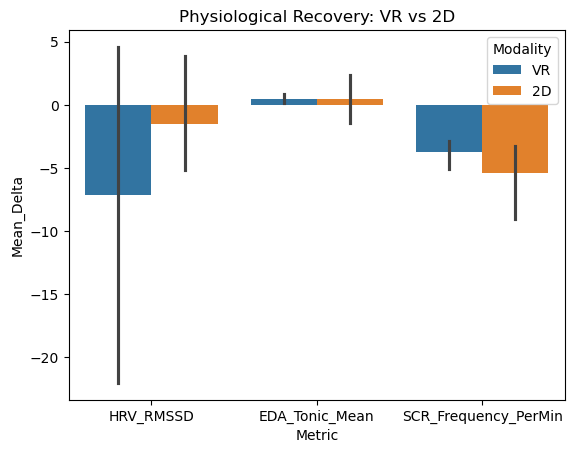

=== FINAL POOLED COMPARISON: VR vs 2D MODALITY ===
                     Metric     Mean_VR     Mean_2D     p_val   cohen_d  \
2                  HRV_SDNN    2.127260    9.836348  0.197932  0.425565   
6  SCR_Peaks_Amplitude_Mean    0.170756    0.100127  0.377030  0.290194   
8      SCR_Frequency_PerMin   -3.750597   -5.481900  0.415311  0.267372   
1                 HRV_RMSSD   -7.298472   -1.920250  0.426221  0.261110   
5              EDA_Tonic_SD    0.494336    0.546214  0.699419  0.126274   
4            EDA_Tonic_Mean    0.449584    0.520334  0.916286  0.034343   
7       Sympathetic_Percent    0.245047    0.251030  0.957617  0.017363   
3                HRV_MeanNN   34.753307   34.470254  0.979989  0.008195   
0             ECG_Rate_Mean   -3.632974   -3.612545  0.986263  0.005625   
9        Unlim_Duration_Blk  130.016211  130.228368  0.994957  0.002065   

  Significant  
2          no  
6          no  
8          no  
1          no  
5          no  
4          no  
7          

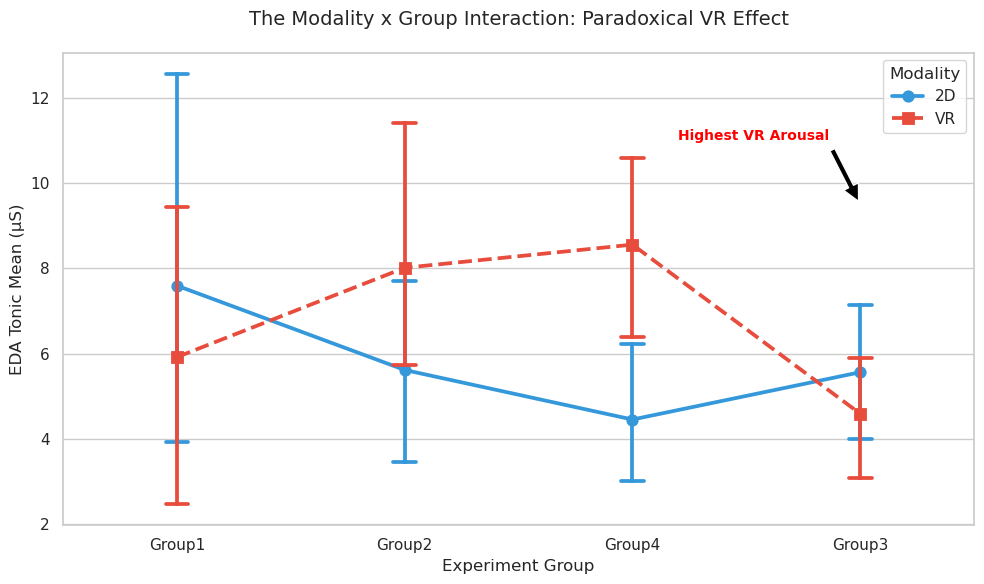

0

In [9]:
main()